# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Msc. BDS - M7 Second Semester Project** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Training Pipeline</span>

## <span style='color:#2656a3'> 🗒️ This notebook is divided into the following sections:
1. Feature selection.
2. Creating a Feature View.
3. Training datasets creation - splitting into train and test sets.
4. Training the model.
5. Register the model to Hopsworks Model Registry.

## <span style='color:#2656a3'> ⚙️ Import of libraries and packages
We start with importing some of the necessary libraries needed for this notebook and warnings to avoid unnecessary distractions and keep output clean.

In [47]:
# Importing the packages and libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [48]:
# First we go one back in our directory to access the folder with our functions
%cd ..

# Now we import the functions from the features folder
# This is the functions we have created to generate features for weather measures and calandar
from features import weather_measures, calendar 

# We go back into the notebooks folder
%cd notebooks

c:\Users\Benj3\OneDrive\Dokumenter\VSCode
[WinError 2] Den angivne fil blev ikke fundet: 'notebooks'
c:\Users\Benj3\OneDrive\Dokumenter\VSCode


## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store
We connect to Hopsworks Feature Store so we can retrieve the Feature Groups and select features for training data.

In [49]:
# Importing the hopsworks module for interacting with the Hopsworks platform
import hopsworks

# Logging into the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store() 

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/556180
Connected. Call `.close()` to terminate connection gracefully.


In [50]:
# Retrieve the feature groups
electricity_fg = fs.get_feature_group(
    name='electricity_prices',
    version=1,
)

weather_fg = fs.get_feature_group(
    name='weather_measurements',
    version=1,
)

danish_calendar_fg = fs.get_feature_group(
    name='dk_calendar',
    version=1,
)

## <span style="color:#2656a3;"> 🖍 Feature View Creation and Retrieving </span>

We first select the features that we want to include for model training.

Since we specified `primary_key`as `date` and `timestamp` in `1_feature_backfill` we can now join them together for the `electricity_fg`, `weather_fg` and `danish_holiday_fg`.

`join_type` specifies the type of join to perform. An inner join refers to only retaining the rows based on the keys present in all joined DataFrames.

In [51]:
# Select features for training data and join them together and except duplicate columns
selected_features_training = electricity_fg.select_all()\
    .join(weather_fg.select_except(["timestamp", "datetime", "hour"]), join_type="inner")\
    .join(danish_calendar_fg.select_all(), join_type="inner")

In [52]:
# transformation_functions = {
#         "hour": fs.get_transformation_function(name="min_max_scaler"),
#         "dk1_spotpricedkk_kwh": fs.get_transformation_function(name="min_max_scaler"),
#         "temperature_2m": fs.get_transformation_function(name="min_max_scaler"),
#         "relative_humidity_2m": fs.get_transformation_function(name="min_max_scaler"),
#         "precipitation": fs.get_transformation_function(name="min_max_scaler"),
#         "rain": fs.get_transformation_function(name="min_max_scaler"),
#         "snowfall": fs.get_transformation_function(name="min_max_scaler"),
#         "weather_code": fs.get_transformation_function(name="min_max_scaler"),
#         "cloud_cover": fs.get_transformation_function(name="min_max_scaler"),
#         "wind_speed_10m": fs.get_transformation_function(name="min_max_scaler"),
#         "wind_gusts_10m": fs.get_transformation_function(name="min_max_scaler"),
#         "dayofweek": fs.get_transformation_function(name="min_max_scaler"),
#         "day": fs.get_transformation_function(name="min_max_scaler"),
#         "month": fs.get_transformation_function(name="min_max_scaler"),
#         "year": fs.get_transformation_function(name="min_max_scaler"),
#         "workday": fs.get_transformation_function(name="min_max_scaler"),
#     }


In [53]:
# Display the first 5 rows of the selected features
selected_features_training.show(5)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.72s) 


,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
0,1682280000000,2023-04-23 20:00:00+00:00,2023-04-23,20,1.02178,10.4,74.0,0.0,0.0,0.0,3.0,100.0,7.6,10.1,6,23,4,2023,0
1,1678816800000,2023-03-14 18:00:00+00:00,2023-03-14,18,0.77461,0.5,88.0,0.0,0.0,0.0,0.0,0.0,11.6,22.7,1,14,3,2023,1
2,1697259600000,2023-10-14 05:00:00+00:00,2023-10-14,5,-0.01551,9.8,71.0,0.0,0.0,0.0,1.0,23.0,29.5,54.7,5,14,10,2023,0
3,1657170000000,2022-07-07 05:00:00+00:00,2022-07-07,5,1.15795,15.0,90.0,0.1,0.1,0.0,51.0,59.0,16.6,31.3,3,7,7,2022,1
4,1647597600000,2022-03-18 10:00:00+00:00,2022-03-18,10,1.48754,8.4,60.0,0.0,0.0,0.0,0.0,0.0,21.9,45.4,4,18,3,2022,1


A `Feature View` stands between the **Feature Groups** and **Training Dataset**. Сombining **Feature Groups** we can create a **Feature View** which stores a metadata of our data. Having the **Feature View** we can create a **Training Dataset**.

In order to create Feature View we can use `fs.get_or_create_feature_view()` method.

We can specify parameters:

- `name` - Name of the feature view to create.
- `version` - Version of the feature view to create.
- `query` - Query object with the data.

In [54]:
# Getting or creating a feature view named 'dk1_electricity_training_feature_view'
version = 1
feature_view_training = fs.get_or_create_feature_view(
    name='dk1_electricity_training_feature_view',
    version=version,
    query=selected_features_training,
)

In [55]:
# # Getting or creating a feature view named 'dk1_electricity_training_feature_view'
# version = 1
# feature_view_training = fs.get_or_create_feature_view(
#     name='lstm_dk1_electricity_training_feature_view',
#     version=version,
#     transformation_functions=transformation_functions,
#     query=selected_features_training,
# )

## <span style="color:#2656a3;"> 🏋️ Training Dataset Creation</span>

In Hopsworks, a training dataset is generated from a query defined by the parent FeatureView, which determines the set of features.

**Training Dataset may contain splits such as:** 
* Training set: This subset of the training data is utilized for model training.
* Validation set: Used for evaluating hyperparameters during model training. *(We have not included a validation set for this project)*
* Test set: Reserved as a holdout subset of training data for evaluating a trained model's performance.

Training dataset is created using `fs.training_data()` method.

In [56]:
# Retrieve training data from the feature view 'feature_view_training', assigning the features to 'X'.
df, _ = feature_view_training.training_data(
    description = 'LSTM Electricity Prices Training Dataset',
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.22s) 


In [57]:
# sort the data by timestamp and reset the index for time series data
df.sort_values(by='timestamp', ascending=True, inplace=True)
df = df.reset_index(drop=True)

df.head()

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
0,1640995200000,2022-01-01 00:00:00+00:00,2022-01-01,0,0.37220,6.7,100.0,0.0,0.0,0.0,3.0,100.0,16.2,36.0,5,1,1,2022,0
1,1640998800000,2022-01-01 01:00:00+00:00,2022-01-01,1,0.30735,6.6,100.0,0.0,0.0,0.0,3.0,100.0,16.2,30.2,5,1,1,2022,0
2,1641002400000,2022-01-01 02:00:00+00:00,2022-01-01,2,0.32141,6.7,99.0,0.0,0.0,0.0,3.0,100.0,15.5,30.6,5,1,1,2022,0
3,1641006000000,2022-01-01 03:00:00+00:00,2022-01-01,3,0.33806,6.7,100.0,0.0,0.0,0.0,3.0,100.0,12.7,28.8,5,1,1,2022,0
4,1641009600000,2022-01-01 04:00:00+00:00,2022-01-01,4,0.28013,6.7,99.0,0.0,0.0,0.0,3.0,100.0,10.6,23.8,5,1,1,2022,0


In [58]:
# Fetching weather forecast measures for the next 5 days
weather_forecast_df = weather_measures.forecast_weather_measures(
    forecast_length=5
)

# Fetching danish calendar
calendar_df = calendar.calendar_denmark()

In [59]:
# Merging the weather forecast and calendar dataframes
new_data = pd.merge(weather_forecast_df, calendar_df, how='inner', left_on='date', right_on='date')

# Displaying the new data
new_data.tail()

,timestamp,datetime,date,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
115,1716663600000,2024-05-25 19:00:00,2024-05-25,19,17.3,82.0,0.0,0.0,0.0,1.0,17.0,9.1,17.6,5,25,5,2024,0
116,1716667200000,2024-05-25 20:00:00,2024-05-25,20,16.0,88.0,0.0,0.0,0.0,1.0,15.0,6.5,14.4,5,25,5,2024,0
117,1716670800000,2024-05-25 21:00:00,2024-05-25,21,15.0,92.0,0.0,0.0,0.0,1.0,12.0,4.3,11.2,5,25,5,2024,0
118,1716674400000,2024-05-25 22:00:00,2024-05-25,22,14.5,94.0,0.0,0.0,0.0,3.0,39.0,3.0,9.7,5,25,5,2024,0
119,1716678000000,2024-05-25 23:00:00,2024-05-25,23,14.2,94.0,0.0,0.0,0.0,3.0,66.0,3.1,8.3,5,25,5,2024,0


In [60]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt




In [61]:
# Features to use
features = ['hour','temperature_2m', 'relative_humidity_2m', 'precipitation', 'rain', 'snowfall', 'weather_code', 
            'cloud_cover', 'wind_speed_10m', 'wind_gusts_10m', 'dayofweek', 'day', 'month', 'year', 'workday']

# Fit the scaler only on the features (excluding the target variable)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_historical_features = scaler.fit_transform(df[features])

# Scale the target variable separately
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_historical_target = target_scaler.fit_transform(df[['dk1_spotpricedkk_kwh']])

# Combine the scaled features and target for creating sequences
scaled_historical_data = np.hstack((scaled_historical_features, scaled_historical_target))

# Scale the new data using the same scaler fitted on the historical features
scaled_new_data = scaler.transform(new_data[features])

In [62]:
# Prepare the data for LSTM
def create_sequences(features, target, time_steps=24):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 24
X_train, y_train = create_sequences(scaled_historical_data, time_steps)

# Prepare the data for LSTM
X_new_data = []
for i in range(len(scaled_new_data) - time_steps + 1):
    X_new_data.append(scaled_new_data[i:(i + time_steps), :])
X_predict = np.array(X_new_data)

In [63]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, len(features))))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5


576/576 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0090 - val_loss: 0.0046
Epoch 2/5
576/576 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0035 - val_loss: 5.1648e-04
Epoch 3/5
576/576 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0023 - val_loss: 9.0141e-04
Epoch 4/5
576/576 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0021 - val_loss: 3.1811e-04
Epoch 5/5
576/576 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0017 - val_loss: 3.2287e-04


In [64]:
# Make predictions
predictions = model.predict(X_new_data)
predictions = target_scaler.inverse_transform(predictions)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


In [65]:
new_data[24:]

,timestamp,datetime,date,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
24,1716336000000,2024-05-22 00:00:00,2024-05-22,0,17.7,47.0,0.0,0.0,0.0,0.0,8.0,20.2,37.4,2,22,5,2024,1
25,1716339600000,2024-05-22 01:00:00,2024-05-22,1,17.0,43.0,0.0,0.0,0.0,0.0,8.0,21.2,37.1,2,22,5,2024,1
26,1716343200000,2024-05-22 02:00:00,2024-05-22,2,16.3,45.0,0.0,0.0,0.0,0.0,11.0,20.9,37.1,2,22,5,2024,1
27,1716346800000,2024-05-22 03:00:00,2024-05-22,3,15.7,50.0,0.0,0.0,0.0,0.0,8.0,20.5,36.4,2,22,5,2024,1
28,1716350400000,2024-05-22 04:00:00,2024-05-22,4,15.5,55.0,0.0,0.0,0.0,0.0,6.0,20.2,35.3,2,22,5,2024,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1716663600000,2024-05-25 19:00:00,2024-05-25,19,17.3,82.0,0.0,0.0,0.0,1.0,17.0,9.1,17.6,5,25,5,2024,0
116,1716667200000,2024-05-25 20:00:00,2024-05-25,20,16.0,88.0,0.0,0.0,0.0,1.0,15.0,6.5,14.4,5,25,5,2024,0
117,1716670800000,2024-05-25 21:00:00,2024-05-25,21,15.0,92.0,0.0,0.0,0.0,1.0,12.0,4.3,11.2,5,25,5,2024,0
118,1716674400000,2024-05-25 22:00:00,2024-05-25,22,14.5,94.0,0.0,0.0,0.0,3.0,39.0,3.0,9.7,5,25,5,2024,0


In [66]:
# Combine predictions with datetime index from new_data (adjust index as needed)
predictions_data = {
    'prediction': predictions.flatten(),  # Ensure predictions is 1D
    'time': new_data['datetime'][24:]  # Adjust index for look_back
}

# Create a DataFrame from the predictions data
predictions_df = pd.DataFrame(predictions_data)

# Display the new electricity price predictions
predictions_df

,prediction,time
24,0.087128,2024-05-22 00:00:00
25,0.037101,2024-05-22 01:00:00
26,0.047374,2024-05-22 02:00:00
27,0.090780,2024-05-22 03:00:00
28,0.142933,2024-05-22 04:00:00
...,...,...
115,0.459359,2024-05-25 19:00:00
116,0.485587,2024-05-25 20:00:00
117,0.505519,2024-05-25 21:00:00
118,0.508054,2024-05-25 22:00:00


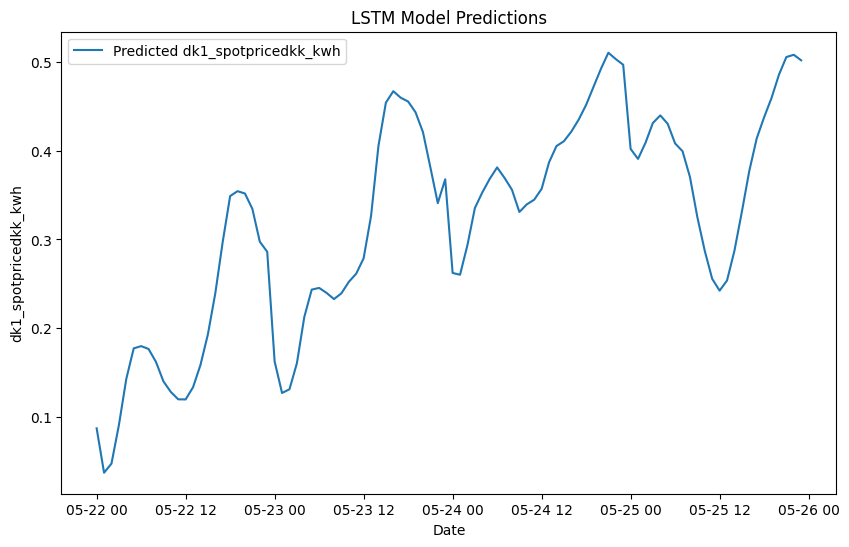

In [68]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(new_data['datetime'][24:], predictions, label='Predicted dk1_spotpricedkk_kwh')
plt.xlabel('Date')
plt.ylabel('dk1_spotpricedkk_kwh')
plt.title('LSTM Model Predictions')
plt.legend()
plt.show()